<a href="https://colab.research.google.com/github/dirknbr/grey-box/blob/main/semi_linear_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi linear model (grey box)

We have outcome y and inputs (Z, x). We suspect some nonlinear effects of Z on y
but don't care about the shape (black box). We do however care that x has a linear relationship with y. So f() will be a full neural network while g() will
be a linear function such as $a x^e$. We want y to be differentiable with respect to x (holding Z constant).   

$y = f(Z) + g(x)$

To restrict e to be in [0, 1] we use the sigmoid over raw e. 

In our simulation all variables are strictly positive.

In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [29]:
# model is y ~ nn(Z) + x

np.random.seed(33)

n = 1000
Z = np.random.gamma(1, 1, (n, 3))
x = np.random.gamma(1, 1, (n, 1))

tf.random.set_seed(22)

class MyModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(1, activation=tf.nn.relu)
    # https://keras.io/api/layers/constraints/
    # self.dense3 = tf.keras.layers.Dense(1, use_bias=False, kernel_constraint=tf.keras.constraints.NonNeg())
    self.beta = tf.Variable(np.random.gamma(1, 1), constraint=tf.keras.constraints.NonNeg())
    # adam cannot do a minmax
    # self.e = tf.Variable(.5, constraint=tf.keras.constraints.MinMaxNorm(0., 1.))
    self.e = tf.Variable(np.random.gamma(1, 1))

  def call(self, inputs):
    Z, x = inputs
    h1 = self.dense1(Z)
    o1 = self.dense2(h1)
    # pred = o1 + self.dense3(x)
    pred = o1 + self.beta * tf.pow(x, tf.nn.sigmoid(self.e))
    return pred

model = MyModel()

In [30]:
tf.nn.sigmoid(0.5)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6224593>

In [31]:
model.compile(loss='mse', optimizer='adam')

In [32]:
# use the model for DGP
y = np.maximum(0, model.predict([Z, x]) + np.random.normal(0, 1, (n, 1)))
y.shape, y.dtype, y.mean(), y.min(), np.mean(y == 0)

((1000, 1), dtype('float64'), 3.4821595260012987, 0.0, 0.022)

In [33]:
model.summary()

Model: "my_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             multiple                  16        
                                                                 
 dense_7 (Dense)             multiple                  5         
                                                                 
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.get_weights()

[array([[-0.07347792,  0.74251044,  0.01457387,  0.20697463],
        [-0.7142915 ,  0.4823625 ,  0.71595514, -0.1558302 ],
        [-0.3803485 ,  0.38671184,  0.5336189 ,  0.4130286 ]],
       dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([[0.9587562 ],
        [0.97319055],
        [0.80466866],
        [0.9913335 ]], dtype=float32),
 array([0.], dtype=float32),
 0.36253706,
 1.3267137]

In [35]:
# initialise a new model
model2 = MyModel()
model2.compile(loss='mse', optimizer='adam')

In [36]:
model2.fit([Z, x], y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: 10.0659
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 9.3061
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 8.3543
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 7.1161
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 5.7177
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 4.6767
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 3.9706
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 3.4650
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 3.1076
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 2.8437
Epoch 11/100
32/32 [==============================] - 0s 2ms/step - loss: 2.6414
Epoch 12/100
32/32 [==============================] - 0s 2ms/step - loss: 2.4679
Epoch 13/100
32/32 [================

In [37]:
pred = model2.predict([Z, x])

print(np.mean(abs(y - pred)))

0.8293572724116847


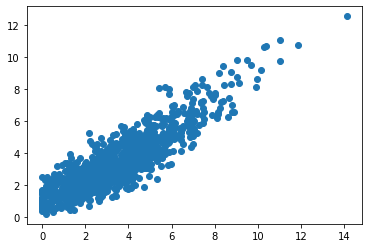

In [38]:
plt.scatter(y, pred)

In [39]:
model2.get_weights()

[array([[-0.26814526,  0.9135039 , -0.14707662,  0.867702  ],
        [-0.22665092,  0.9577994 , -0.26810634,  0.7538159 ],
        [ 0.33264878,  1.2065213 ,  0.7597398 , -0.22329159]],
       dtype=float32),
 array([ 0.14241707, -0.04445745, -0.06263687, -0.24936366], dtype=float32),
 array([[-0.4954785 ],
        [ 0.83693296],
        [ 0.5287038 ],
        [ 0.2293178 ]], dtype=float32),
 array([0.04566088], dtype=float32),
 0.51276636,
 0.36446375]

In [40]:
np.corrcoef(y.squeeze(), pred.squeeze())

array([[1.        , 0.87742021],
       [0.87742021, 1.        ]])